# Train Trading Bot
This notebook trains the trading bot using the features found in feature_selection.ipynb

Training 1:
- trading_model_1.model

Training 2:
- trading_model_2.model, Changed to multi:softprob from multi:softmax in params to get probability of each class instead of max class.

In [23]:
import glob
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define hyperparameters
params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "mlogloss",
}

num_round = 100  # Number of boosting rounds
model_file = "trading_model_2.model"  # Model file name
batch_size = 10  # Number of CSVs to process per iteration

# Get list of all CSV files
parquet_files = sorted(glob.glob("data/enriched/balanced/*.parquet"))

bst = None  # Initialize model

print(f"Found {len(parquet_files)} parquet files.")

for i in range(0, len(parquet_files), batch_size):
    batch_files = parquet_files[i : i + batch_size]  # Get batch of files
    print(f"Processing batch {i // batch_size + 1} with {len(batch_files)} files...")

    # Load and concatenate batch of CSVs
    df_list = [pd.read_parquet(file, engine="pyarrow") for file in batch_files]
    df = pd.concat(df_list, ignore_index=True)
    
    # Split dataset into train and test
    X = df.drop(columns=["target", "symbol", "timestamp", "future_close"])
    y = df["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Compute class weights for balancing
    target_counts = y_train.value_counts()
    num_0 = target_counts.max()  # Take largest class as reference
    weights = y_train.map(lambda x: num_0 / target_counts[x])

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train model incrementally
    if bst is None:
        bst = xgb.train(params, dtrain, num_boost_round=num_round)
    else:
        bst = xgb.train(params, dtrain, num_boost_round=num_round, xgb_model=bst)

    # Evaluate on test data (get predicted probabilities)
    y_pred_proba = bst.predict(dtest)  # Gives probabilities for each class
    y_pred = y_pred_proba.argmax(axis=1)  # Select class with highest probability

    print(f"Batch {i // batch_size + 1} Accuracy: {accuracy_score(y_test, y_pred)}")

# Save final model
bst.save_model("./data/models/" + model_file)
print(f"Model saved as {model_file}")

# Feature importance analysis
importance = bst.get_score(importance_type="weight")
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for feature, score in sorted_importance:
    print(f"Feature: {feature}, Score: {score}")


Found 200 parquet files.
Processing batch 1 with 10 files...
Batch 1 Accuracy: 0.5677834511808302
Processing batch 2 with 10 files...
Batch 2 Accuracy: 0.5806789314816899
Processing batch 3 with 10 files...
Batch 3 Accuracy: 0.5894983101141741
Processing batch 4 with 10 files...
Batch 4 Accuracy: 0.5966757331249648
Processing batch 5 with 10 files...
Batch 5 Accuracy: 0.6003920354223578
Processing batch 6 with 10 files...
Batch 6 Accuracy: 0.6048415154683051
Processing batch 7 with 10 files...
Batch 7 Accuracy: 0.6085017601269275
Processing batch 8 with 10 files...
Batch 8 Accuracy: 0.6116562168040975
Processing batch 9 with 10 files...
Batch 9 Accuracy: 0.615217843923829
Processing batch 10 with 10 files...
Batch 10 Accuracy: 0.6184481074900504
Processing batch 11 with 10 files...
Batch 11 Accuracy: 0.6213851683604178
Processing batch 12 with 10 files...
Batch 12 Accuracy: 0.6235790101201061
Processing batch 13 with 10 files...
Batch 13 Accuracy: 0.6258417510109858
Processing batch 14

C:\Users\aolivest\AppData\Local\Temp\ipykernel_32796\622992346.py:64: UserWarning: [12:16:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  bst.save_model("./data/models/" + model_file)


Model saved as trading_model_2.model

Feature Importances:
Feature: sp_sma, Score: 56958.0
Feature: sp_volatility, Score: 34569.0
Feature: hour, Score: 30709.0
Feature: minute, Score: 29552.0
Feature: sp_return_10m, Score: 27734.0
Feature: hist_volatility, Score: 21087.0
Feature: atr, Score: 19427.0
Feature: sp_log_return, Score: 18358.0
Feature: rsi, Score: 16081.0
Feature: volatility, Score: 15662.0
Feature: trade_count, Score: 15361.0
Feature: day_of_week, Score: 14428.0
Feature: volume, Score: 13296.0
Feature: roc, Score: 12511.0
Feature: log_return, Score: 11177.0
Feature: open, Score: 9314.0
Feature: low, Score: 6624.0
Feature: high, Score: 6591.0
Feature: close, Score: 4781.0
Feature: vwap, Score: 3456.0
Feature: is_market_close, Score: 2493.0
Feature: is_market_open, Score: 270.0


# Test Model

#### Trading Bot vs Buy & Hold:

Single stock:

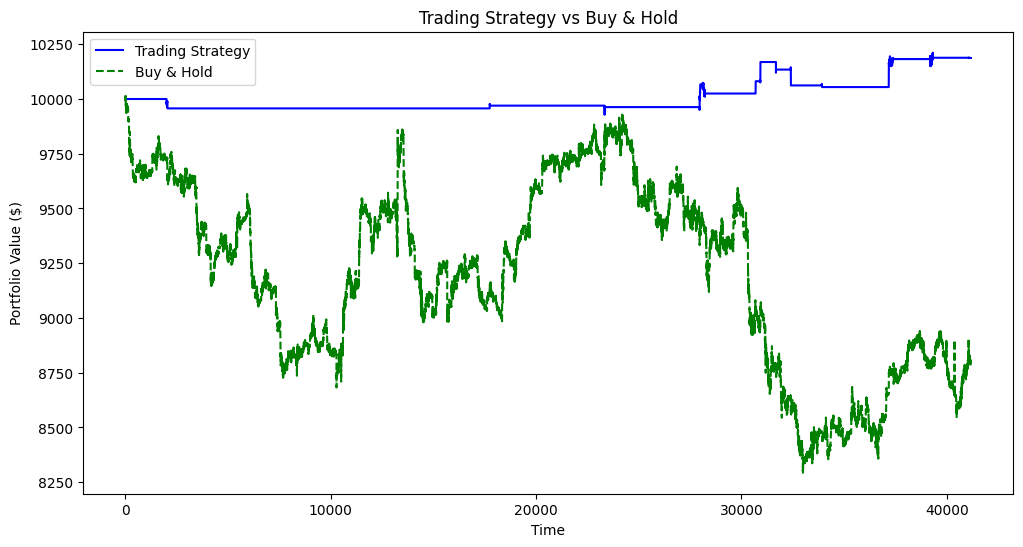

Buy Signals: 13, Sell Signals: 13


,Trading Bot,Buy & Hold
Initial Cash,10000,10000
End Cash,10187.5,8795.8
Return,1.9%,-12.0%


In [55]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load unseen test data
df_test = pd.read_parquet("data/test/test__apple.parquet")

# Extract features and actual prices
X_test = df_test.drop(columns=["target", "symbol", "timestamp", "future_close"])
actual_prices = df_test["close"]

# Load trained model
model = xgb.Booster()
model.load_model("data/models/trading_model_2.model")

# Convert test data to DMatrix and predict
dtest = xgb.DMatrix(X_test)
pred_prob = model.predict(dtest)
df_test["prediction"] = np.argmax(pred_prob, axis=1)
df_test["confidence"] = np.max(pred_prob, axis=1)
df_test['prediction'] = df_test['prediction'].round().astype(int)

# Simulate trading strategy
initial_cash = 10000  # Starting with $10,000
cash = initial_cash
stocks_held = 0
portfolio_values = []  # Portfolio values over time

# Buy & Hold Strategy (Baseline)
hold_portfolio = [initial_cash * (actual_prices[i] / actual_prices[0]) for i in range(len(actual_prices))]

buy_signals = 0
sell_signals = 0
# Strategy Simulation
for i in range(len(df_test)):
    
    if df_test["prediction"].iloc[i] == 1 and cash > 0 and df_test["confidence"].iloc[i] > 0.75:  # Buy Signal
        buy_signals += 1
        stocks_held = stocks_held + (cash / actual_prices.iloc[i])  # Buy as many shares as possible
        cash = 0
    elif df_test["prediction"].iloc[i] == 2 and stocks_held > 0:  # Sell Signal
        sell_signals += 1
        cash = stocks_held * actual_prices.iloc[i]  # Sell all shares
        stocks_held = 0

    # Portfolio value = cash + stock value
    portfolio_values.append(cash + (stocks_held * actual_prices.iloc[i]))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, portfolio_values, label="Trading Strategy", color="blue")
plt.plot(df_test.index, hold_portfolio, label="Buy & Hold", color="green", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.title("Trading Strategy vs Buy & Hold")
plt.show()

print(f"Buy Signals: {buy_signals}, Sell Signals: {sell_signals}")

# Create a DataFrame to store the comparison table
data = {
    'Trading Bot': [initial_cash, (cash + (stocks_held * actual_prices.iloc[-1])).round(1), f'{((((cash + (stocks_held * actual_prices.iloc[-1]))/initial_cash)-1)*100).round(1)}%'],  # Example data: initial cash, end cash, return
    'Buy & Hold': [initial_cash, hold_portfolio[-1].round(1), f'{(((hold_portfolio[-1]/initial_cash) - 1)*100).round(1)}%'],  # Example data: initial cash, end cash, return
}

# Define the row labels
rows = ['Initial Cash', 'End Cash', 'Return']

# Create DataFrame
df_comparison = pd.DataFrame(data, index=rows)

# Print the table
df_comparison


Several stocks:

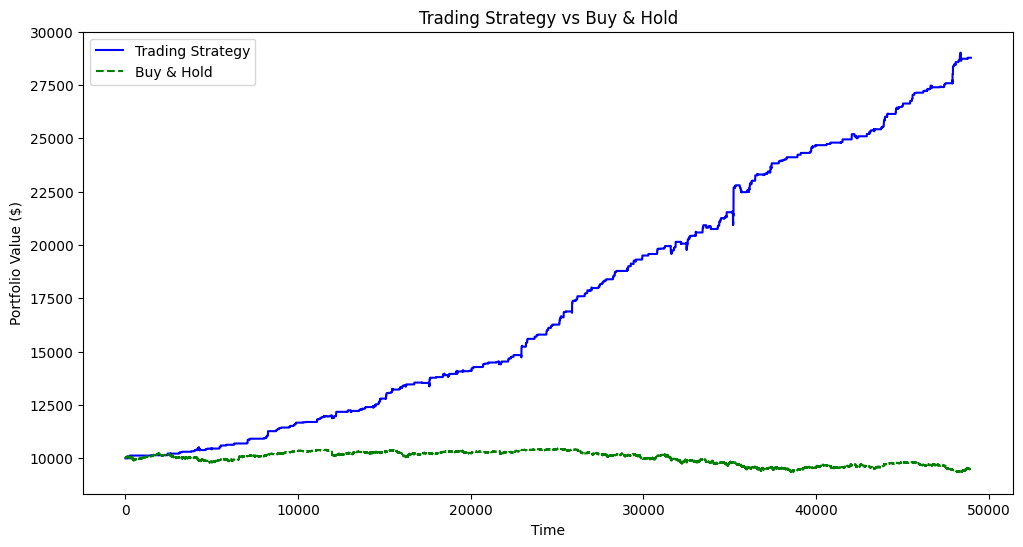

Buy Signals: 439, Sell Signals: 413


,Trading Bot,Buy & Hold
Initial Cash,10000,10000
End Cash,28780.0,9492.1
Return,187.8%,-5.1%


: 

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load unseen test data
df_test = pd.read_parquet("data/test/test__nasdaq_100.parquet")
df_hold = pd.read_parquet("data/test/test__spy.parquet")

# Find common timestamps
common_timestamps = set(df_test["timestamp"]).intersection(df_hold["timestamp"])

# Filter both DataFrames
df_test = df_test[df_test["timestamp"].isin(common_timestamps)].reset_index(drop=True)
df_hold = df_hold[df_hold["timestamp"].isin(common_timestamps)].reset_index(drop=True)

# Extract features and actual prices
X_test = df_test.drop(columns=["target", "symbol", "timestamp", "future_close"])
actual_prices_hold = df_hold["close"]

# Load trained model
model = xgb.Booster()
model.load_model("data/models/trading_model_2.model")

# Convert test data to DMatrix and predict
dtest = xgb.DMatrix(X_test)
pred_prob = model.predict(dtest)
df_test["prediction"] = np.argmax(pred_prob, axis=1)
df_test["confidence"] = np.max(pred_prob, axis=1)
df_test['prediction'] = df_test['prediction'].round().astype(int)

# Simulate trading strategy
initial_cash = 10000  # Starting with $10,000
cash = initial_cash
stocks_held = {symbol: 0 for symbol in df["symbol"].unique()}
stock_prices = {}
portfolio_values = []  # Portfolio values over time

# Buy & Hold Strategy (Baseline)
hold_portfolio = [initial_cash * (actual_prices_hold[i] / actual_prices_hold[0]) for i in range(len(actual_prices_hold))]

buy_signals = 0
sell_signals = 0
total_value = initial_cash
new_timestamp = df_test["timestamp"].iloc[0]
confidence = 0.85
buy_power = 0.25
# Strategy Simulation
for i in range(len(df_test)):
    if df_test["timestamp"].iloc[i] != new_timestamp:
        portfolio_values.append(total_value)
        new_timestamp = df_test["timestamp"].iloc[i]
    stock = df_test["symbol"].iloc[i]
    stock_prices[stock] = df_test["close"].iloc[i]
    
    if df_test["prediction"].iloc[i] == 1 and cash >= (total_value*buy_power)  and df_test["confidence"].iloc[i] > confidence:  # Buy Signal
        buy_signals += 1
        stocks_held[stock] = stocks_held[stock] + ((total_value*buy_power) / stock_prices[stock])  # Buy
        cash = cash - (total_value*buy_power)
    elif df_test["prediction"].iloc[i] == 2 and stocks_held[stock] > 0:  # Sell Signal
        sell_signals += 1
        cash = cash + stocks_held[stock] * stock_prices[stock]  # Sell all shares
        stocks_held[stock] = 0

    stock_value = 0
    for stock, hold in stocks_held.items():
        if hold > 0:
            stock_value += hold * stock_prices[stock]
    total_value = cash + stock_value
# Add last timestamp value
portfolio_values.append(total_value)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_hold.index, portfolio_values, label="Trading Strategy", color="blue")
plt.plot(df_hold.index, hold_portfolio, label="Buy & Hold", color="green", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.title("Trading Strategy vs Buy & Hold")
plt.show()

print(f"Buy Signals: {buy_signals}, Sell Signals: {sell_signals}")

# Create a DataFrame to store the comparison table
data = {
    'Trading Bot': [initial_cash, total_value.round(1), f'{(((total_value/initial_cash)-1)*100).round(1)}%'],  # Example data: initial cash, end cash, return
    'Buy & Hold': [initial_cash, hold_portfolio[-1].round(1), f'{(((hold_portfolio[-1]/initial_cash) - 1)*100).round(1)}%'],  # Example data: initial cash, end cash, return
}
rows = ['Initial Cash', 'End Cash', 'Return']
df_comparison = pd.DataFrame(data, index=rows)
df_comparison
